In [1]:
!pip install pystan==2.19.1.1
!pip install prophet

In [1]:
import os
import glob
import csv
import sys
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.linear_model import BayesianRidge

from darts.metrics import mae
from darts.metrics import mse
from darts.metrics import rmse

import random
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
from prophet.plot import add_changepoints_to_plot
import datetime

from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler

In [3]:
def interpolate_method(df,column_name,methode,direction,order,limit):
    df[column_name] = df[column_name].interpolate(method=methode,limit_direction = direction,order=order,limit=limit)
    return df

def clean_csv(df,time_variable,quantitative_variable):
    df = df[[time_variable, quantitative_variable]].copy()
    df.columns = ['ds','y']
    df['y'] = (df['y'].apply(pd.to_numeric, errors='coerce')).to_frame()
    df = df.drop_duplicates(subset=['ds'])
    df['ds'] = pd.to_datetime(df.ds, errors = 'coerce')
    df = df.dropna(subset=['ds'])
    df = df.sort_values(by=['ds'])
    pourcentage = ((len(df) - df['y'].count()) / len(df)) * 100
    #if (pourcentage <= 2):
    #  df = df.dropna(subset=['y'])

    if(pourcentage < 25):
        df = interpolate_method(df,'y',"polynomial",None,2,None)
    elif((pourcentage >= 25)):
        print("La base de donnée comporte un grand nombre de données manquantes pour être étudiée.")
    if(len(df) > 1000):
        supr = len(df) - 1000
        df = df[:-supr]
    return df, pourcentage

In [4]:
def naive_method(df):
  if len(df.columns) > 2:
    print("Erreur : il y a plus d'une seule variable")
  elif(len(df) < 500):
      print("Erreur : le data frame est trop petit")
  else:
    n = len(df)
    period = 100
    train_len = n-period
    train = df[0:train_len]
    val = df[train_len:]
    
    series = TimeSeries.from_dataframe(df, 'ds', 'y')
    train_scaled = TimeSeries.from_dataframe(train, 'ds', 'y')
    val_scaled = TimeSeries.from_dataframe(val, 'ds', 'y')
    
    scaler = Scaler()
    train_scaled = scaler.fit_transform(train_scaled)
    val_scaled = scaler.transform(val_scaled)
    series_scaled = scaler.transform(series)
        
    y_hat_naive = val.copy()
    y_hat_naive['naive_forecast'] = train['y'][train_len-1]
    
    y_hat_naive_scaled = TimeSeries.from_dataframe(y_hat_naive, 'ds', 'naive_forecast')
    y_hat_naive_scaled = scaler.transform(y_hat_naive_scaled)
    
    MAE = mae(val_scaled,y_hat_naive_scaled)
    MSE = mse(val_scaled,y_hat_naive_scaled)
    RMSE = rmse(val_scaled,y_hat_naive_scaled)


    return(train_scaled, val_scaled, y_hat_naive_scaled, MAE, MSE, RMSE)

In [5]:
def prophet_model(df,frequency):
  if len(df.columns) > 2:
    print("Erreur : il y a plus d'une seule variable")
  elif(len(df) < 500):
    print("Erreur : le data frame est trop petit")
  else:
    n = len(df)
    period = 100
    df_fit = df[:-period]
    df_true = df[n-period:]
    
    series = TimeSeries.from_dataframe(df, 'ds', 'y')
    train = TimeSeries.from_dataframe(df_fit, 'ds', 'y')
    val = TimeSeries.from_dataframe(df_true, 'ds', 'y')
    
    scaler = Scaler()
    train_scaled = scaler.fit_transform(train)
    val_scaled = scaler.transform(val)
    series_scaled = scaler.transform(series)
    
    m = Prophet(daily_seasonality=True, weekly_seasonality=True, yearly_seasonality = True)
    m.fit(df_fit)
    future = m.make_future_dataframe(periods=period*2, freq=frequency)
    if (frequency == 'M'):
        for i in range (n-period, len(future)):
            future['ds'][i] = future['ds'][i] + datetime.timedelta(days=1)
    forecast = m.predict(future)
    df_true_prediction = pd.merge(df_true, forecast, how ='inner', on =['ds'])
    df_true_prediction = df_true_prediction[['ds', 'y', 'yhat', 'yhat_upper', 'yhat_lower']].copy()
    
    pred = TimeSeries.from_dataframe(df_true_prediction, 'ds', 'yhat')
    pred_scaled = scaler.transform(pred)
    
    MAE = mae(val_scaled,pred_scaled)
    MSE = mse(val_scaled,pred_scaled)
    RMSE = rmse(val_scaled, pred_scaled)
    
    return(train_scaled, val_scaled, pred_scaled, MAE, MSE, RMSE)

In [6]:
os.getcwd()

'/home/nazim/MAIN4/Transformers/Code/900-100'

In [7]:
os.chdir('../../Datasets/Climat')
os.getcwd()

'/home/nazim/MAIN4/Transformers/Datasets/Climat'

In [8]:
!ls

M-data_Afghanistan.csv	    M-data_Benin.csv
M-data_Albania.csv	    M-data_Bolivia.csv
M-data_Algeria.csv	    M-data_Bosnia_H.csv
M-data_Andorra.csv	    M-data_Botswana.csv
M-data_Antigua_Barbada.csv  M-data_British_Virgin_Island.csv
M-data_Armenia.csv	    M-data_Burma.csv
M-data_Azerbaijan.csv	    M-data_Cameroon.csv
M-data_Bahamas.csv	    M-data_Colombia.csv
M-data_Baker_Island.csv     M-data_Costa_Rica.csv
M-data_Belgium.csv


In [9]:
def predict():
    file_name = []
    df = []
    pourcentage = []

    df_fit_naive = []
    df_true_prediction_naive = []
    forecast_naive = []

    df_fit_prophet = []
    df_true_prediction_prophet = []
    forecast_prophet = []

    results_naive = pd.DataFrame(columns=['DATA_SET_NAME','Method','MAE','MSE','RMSE'])
    results_prophet = pd.DataFrame(columns=['DATA_SET_NAME','Method','MAE','MSE','RMSE'])

    i = 0
    for files in glob.glob("*.csv"):
        file_name.append(Path(files).stem)
        print(file_name[i])
        df_not_cleaned = pd.read_csv(files)
        df_clean, pourcentage_actual = clean_csv(df_not_cleaned, "Date","Value")
        df.append(df_clean)
        pourcentage.append(pourcentage_actual)
        
        df_fit_temp_naive , df_true_prediction_temp_naive , forecast_temp_naive , MAE_naive, MSE_naive, RMSE_naive = naive_method(df[i])
        df_fit_naive.append(df_fit_temp_naive)
        df_true_prediction_naive.append(df_true_prediction_temp_naive)
        forecast_naive.append(forecast_temp_naive)

        df_fit_temp_prophet , df_true_prediction_temp_prophet , forecast_temp_prophet , MAE_prophet, MSE_prophet, RMSE_prophet = prophet_model(df[i],file_name[i][0])
        df_fit_prophet.append(df_fit_temp_prophet)
        df_true_prediction_prophet.append(df_true_prediction_temp_prophet)
        forecast_prophet.append(forecast_temp_prophet)

        df_new_row_naive = pd.DataFrame(data=np.array([[file_name[i],'Naive Method',MAE_naive,MSE_naive,RMSE_naive]]), columns=['DATA_SET_NAME','Method','MAE','MSE','RMSE'])
        df_new_row_prophet = pd.DataFrame(data=np.array([[file_name[i],'Prophet Method',MAE_prophet,MSE_prophet,RMSE_prophet]]), columns=['DATA_SET_NAME','Method','MAE','MSE','RMSE'])
        results_naive = pd.concat([results_naive,df_new_row_naive], ignore_index=True)
        results_prophet = pd.concat([results_prophet,df_new_row_prophet], ignore_index=True)
        i = i +1

    return file_name,df, pourcentage, df_fit_naive, df_true_prediction_naive, forecast_naive, results_naive, df_fit_prophet, df_true_prediction_prophet, forecast_prophet, results_prophet

In [10]:
file_name, df, pourcentage, df_fit_naive, df_true_prediction_naive, forecast_naive, results_naive, df_fit_prophet, df_true_prediction_prophet, forecast_prophet, results_prophet = predict()

M-data_Bahamas
Initial log joint probability = -5.51976
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2948.92    0.00616723       484.985           1           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2949.89   1.44532e-05       69.2931           1           1      251   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     239       2949.98   2.18459e-05       124.554   2.341e-07       0.001      342  LS failed, Hessian reset 
     299       2950.02   9.07457e-07       70.0822      0.6368      0.6368      414   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     318       2950.02   1.07612e-05       85.4074   1.112e-07       0.001      481  LS failed, Hessian reset 
     354       2950.02    4.2952e-07       73.1596   4.863e-09       0.001      566  LS faile

M-data_Andorra
Initial log joint probability = -97.4076
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2206.18    0.00321937       174.982      0.9969      0.9969      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     153       2206.54    6.3252e-05       84.6258   8.465e-07       0.001      225  LS failed, Hessian reset 
     180       2206.54   6.04283e-08       55.2513     0.04053           1      260   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
M-data_Azerbaijan
Initial log joint probability = -145.015
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2199.91   0.000512714       81.1769           1           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2201.17   2.83626e-05   

M-data_Benin
Initial log joint probability = -4.70927
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3297.78    0.00109971       415.902           1           1      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3301.01   0.000340792       264.893      0.4829    0.004829      253   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     248       3301.62   5.04901e-05       510.619   1.196e-07       0.001      361  LS failed, Hessian reset 
     299       3301.97   4.13926e-05       150.279       0.458       0.458      417   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     395       3302.38   9.65315e-06       124.746   9.393e-08       0.001      603  LS failed, Hessian reset 
     399       3302.43    0.00011199       180.737      0.9486      0.9486      608   
    Iter

In [11]:
df

[            ds       y
 0   1887-05-01  24.758
 1   1887-06-01  26.902
 2   1887-07-01  28.106
 3   1887-08-01  27.844
 4   1887-09-01  26.937
 ..         ...     ...
 995 1970-04-01  25.273
 996 1970-05-01  25.619
 997 1970-06-01  27.377
 998 1970-07-01  28.384
 999 1970-08-01  28.719
 
 [1000 rows x 2 columns],
             ds       y
 0   1883-02-01  24.152
 1   1883-03-01  23.994
 2   1883-04-01  24.571
 3   1883-05-01  25.696
 4   1883-06-01  26.860
 ..         ...     ...
 995 1966-01-01  24.878
 996 1966-02-01  24.859
 997 1966-03-01  25.302
 998 1966-04-01  25.736
 999 1966-05-01  26.542
 
 [1000 rows x 2 columns],
             ds       y
 0   1871-01-01  21.704
 1   1871-02-01  21.119
 2   1871-03-01  21.750
 3   1871-04-01  20.687
 4   1871-05-01  18.368
 ..         ...     ...
 995 1953-12-01  22.932
 996 1954-01-01  22.203
 997 1954-02-01  22.008
 998 1954-03-01  21.475
 999 1954-04-01  21.126
 
 [1000 rows x 2 columns],
             ds       y
 0   1801-05-01  17.825
 1  

In [12]:
results_naive

DATA_SET_NAME        Method                  MAE  \
0                 M-data_Bahamas  Naive Method   0.2463237045650457   
1   M-data_British_Virgin_Island  Naive Method  0.34300197206188815   
2                 M-data_Bolivia  Naive Method  0.21510758178494777   
3                 M-data_Albania  Naive Method  0.24233597698182754   
4            M-data_Baker_Island  Naive Method   0.0530195324117408   
5                 M-data_Algeria  Naive Method   0.3356764950831973   
6                 M-data_Andorra  Naive Method  0.37540550133096706   
7              M-data_Azerbaijan  Naive Method  0.36806646138054916   
8                 M-data_Belgium  Naive Method  0.19330028640669752   
9                   M-data_Burma  Naive Method   0.2622486537055353   
10            M-data_Afghanistan  Naive Method   0.3477085111571759   
11               M-data_Cameroon  Naive Method  0.22475655970498526   
12                M-data_Armenia  Naive Method  0.35178835335259245   
13             M-data_Costa_Rica  Naive Method  0.22120237195604936   
14                  M-data_Benin  Naive Method  0.21997115780799345   
15               M-data_Bosnia_H  Naive Method   0.1350623862560864   
16               M-data_Botswana  Naive Method  0.22289599769703153   
17        M-data_Antigua_Barbada  Naive Method  0.23052717331194358   
18               M-data_Colombia  Naive Method  0.10449331675449482   

                     MSE                 RMSE  
0    0.08217828489861637  0.28666755117839265  
1    0.16196420880358298  0.40244777152269456  
2    0.08989068973469189  0.29981776087265394  
3    0.07472438517517102   0.2733576140793796  
4   0.003955545857810602  0.06289313045007858  
5    0.16747855186089872  0.40924143468238733  
6     0.2030440794596454  0.45060412721106474  
7    0.21029394563987258   0.4585781783293581  
8    0.04843161550742047   0.2200718416958891  
9    0.12364585764391445  0.35163312933214136  
10   0.18995717233851084  0.43584076488840606  
11   0.06585273590746615  0.25661787916563056  
12   0.18563848461826774  0.43085784734442023  
13   0.06228102265391253  0.24956166102571228  
14   0.08705887433829629   0.2950574085467035  
15  0.028009214407392714  0.16735953635031592  
16   0.08046654722131656   0.2836662602801337  
17   0.09226963336678619  0.30375917001267005  
18  0.017917739961325504   0.1338571625327741

In [13]:
results_prophet

DATA_SET_NAME          Method                   MAE  \
0                 M-data_Bahamas  Prophet Method  0.045969395449071825   
1   M-data_British_Virgin_Island  Prophet Method   0.07371381321046988   
2                 M-data_Bolivia  Prophet Method   0.06210225455519712   
3                 M-data_Albania  Prophet Method   0.03801639095740852   
4            M-data_Baker_Island  Prophet Method   0.03755537647768702   
5                 M-data_Algeria  Prophet Method   0.03448704339571068   
6                 M-data_Andorra  Prophet Method   0.04043099396959542   
7              M-data_Azerbaijan  Prophet Method   0.03646321979409853   
8                 M-data_Belgium  Prophet Method   0.05717001420029708   
9                   M-data_Burma  Prophet Method   0.04484752816678256   
10            M-data_Afghanistan  Prophet Method   0.03649615316855968   
11               M-data_Cameroon  Prophet Method   0.07018185499243534   
12                M-data_Armenia  Prophet Method  0.041189370856380574   
13             M-data_Costa_Rica  Prophet Method   0.08448969356956063   
14                  M-data_Benin  Prophet Method  0.059138686391239675   
15               M-data_Bosnia_H  Prophet Method  0.016747251500941814   
16               M-data_Botswana  Prophet Method   0.05143887132926277   
17        M-data_Antigua_Barbada  Prophet Method   0.08538564381968092   
18               M-data_Colombia  Prophet Method    0.1013646052492738   

                       MSE                  RMSE  
0    0.0035281982647671754  0.059398638576714666  
1     0.008865215640815912   0.09415527409983952  
2     0.006784138102894954   0.08236587948231328  
3     0.002438802293401461    0.0493842312221367  
4    0.0022008002406839213  0.046912687416986905  
5     0.001731614794527339   0.04161267588761072  
6    0.0026205215065588754  0.051191029551659495  
7     0.002150902192130337    0.0463778200450424  
8    0.0051496548717112865   0.07176109580901957  
9     0.003492976572584625    0.0591014092267234  
10   0.0020787850279676812  0.045593695046219726  
11     0.00853912340144037   0.09240737741890725  
12    0.002803451259300594   0.05294762751342683  
13    0.011350885707415565     0.106540535513088  
14    0.005776999294524494   0.07600657402175481  
15  0.00041333014739810663  0.020330522555952826  
16    0.003924935471382013   0.06264930543415476  
17    0.009715174753528504   0.09856558605075355  
18    0.015488042332538586   0.12445096356613149

In [14]:
results_prophet.to_csv(r'../../Resultats/Resultats_100/prophet_results_climat.csv', index = False)
results_naive.to_csv(r'../../Resultats/Resultats_100/naive_results_climat.csv', index = False)

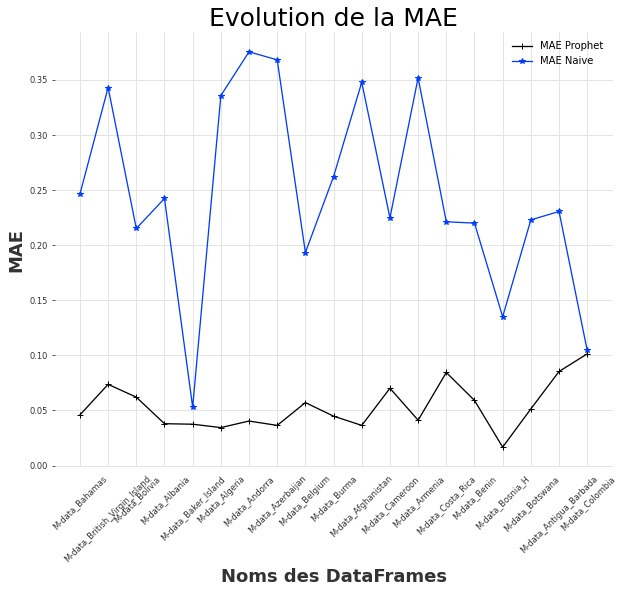

In [15]:
figure(figsize=(10, 8))
plt.axes()

liste_MAE1_prophet = results_prophet["MAE"].tolist()
liste_MAE_prophet = [float(item) for item in liste_MAE1_prophet]

liste_MAE1_naive = results_naive["MAE"].tolist()
liste_MAE_naive = [float(item) for item in liste_MAE1_naive]

x = np.array([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18])
y = np.array(liste_MAE_prophet)
y2 = np.array(liste_MAE_naive)

liste_NAME = results_prophet["DATA_SET_NAME"].tolist()
my_xticks = liste_NAME
plt.xticks(x, my_xticks)
plt.xticks(rotation=45)
plt.plot(x, y, label = 'MAE Prophet', marker="+")
plt.plot(x, y2, label = 'MAE Naive', marker="*")
plt.title("Evolution de la MAE",fontsize=25)
plt.xlabel("Noms des DataFrames",fontsize=18)
plt.ylabel("MAE",fontsize=18)
plt.legend()
plt.show()

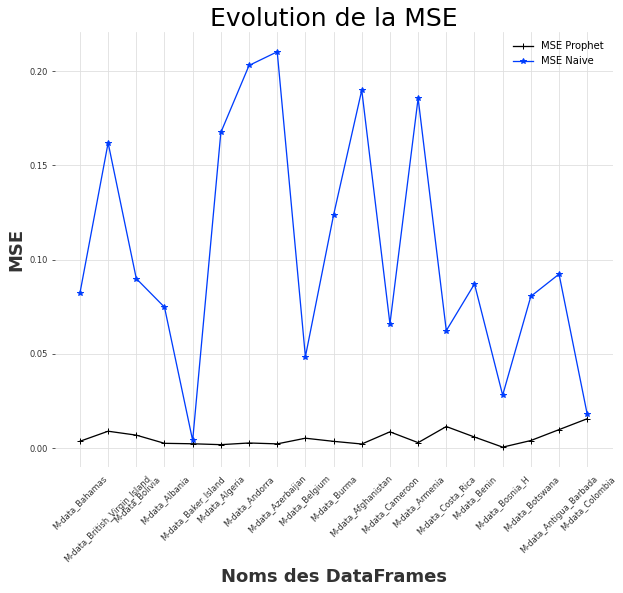

In [16]:
figure(figsize=(10, 8))
plt.axes()

liste_MSE1_prophet = results_prophet["MSE"].tolist()
liste_MSE_prophet = [float(item) for item in liste_MSE1_prophet]

liste_MSE1_naive = results_naive["MSE"].tolist()
liste_MSE_naive = [float(item) for item in liste_MSE1_naive]

x = np.array([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18])
y = np.array(liste_MSE_prophet)
y2 = np.array(liste_MSE_naive)

liste_NAME = results_prophet["DATA_SET_NAME"].tolist()
my_xticks = liste_NAME
plt.xticks(x, my_xticks)
plt.xticks(rotation=45)
plt.plot(x, y, label = 'MSE Prophet', marker="+")
plt.plot(x, y2, label = 'MSE Naive', marker="*")
plt.title("Evolution de la MSE",fontsize=25)
plt.xlabel("Noms des DataFrames",fontsize=18)
plt.ylabel("MSE",fontsize=18)
plt.legend()
plt.show()

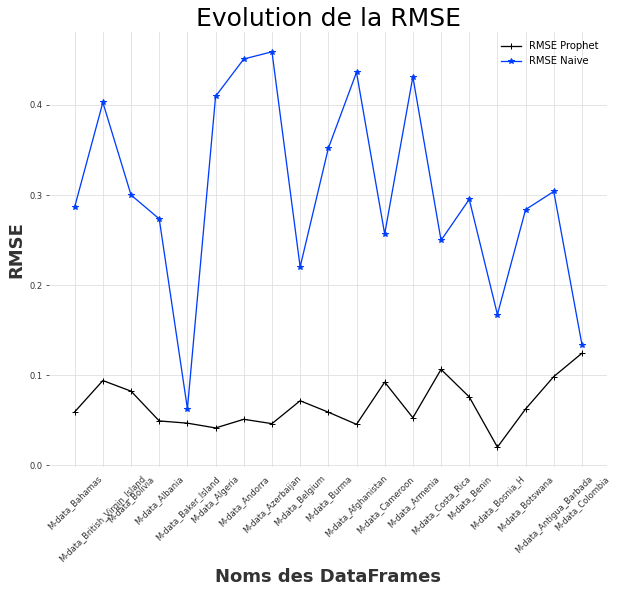

In [17]:
figure(figsize=(10, 8))
plt.axes()

liste_RMSE1_prophet = results_prophet["RMSE"].tolist()
liste_RMSE_prophet = [float(item) for item in liste_RMSE1_prophet]

liste_RMSE1_naive = results_naive["RMSE"].tolist()
liste_RMSE_naive = [float(item) for item in liste_RMSE1_naive]

x = np.array([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18])
y = np.array(liste_RMSE_prophet)
y2 = np.array(liste_RMSE_naive)

liste_NAME = results_prophet["DATA_SET_NAME"].tolist()
my_xticks = liste_NAME
plt.xticks(x, my_xticks)
plt.xticks(rotation=45)
plt.plot(x, y, label = 'RMSE Prophet', marker="+")
plt.plot(x, y2, label = 'RMSE Naive', marker="*")
plt.title("Evolution de la RMSE",fontsize=25)
plt.xlabel("Noms des DataFrames",fontsize=18)
plt.ylabel("RMSE",fontsize=18)
plt.legend()
plt.show()

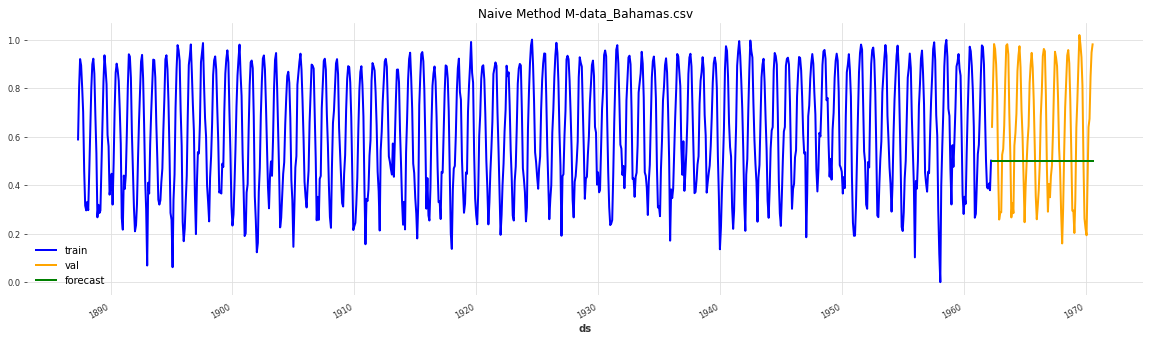

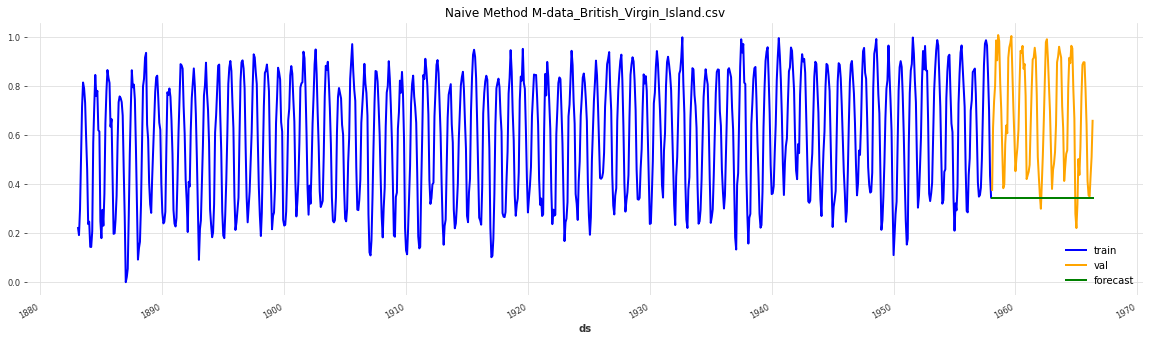

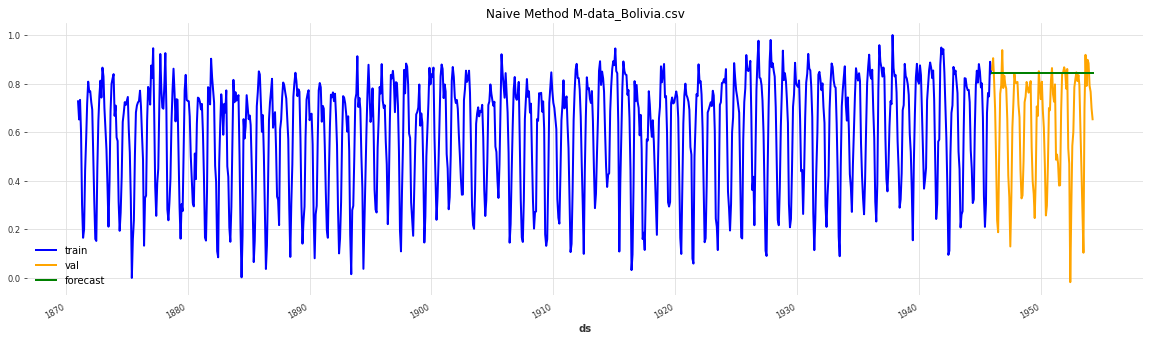

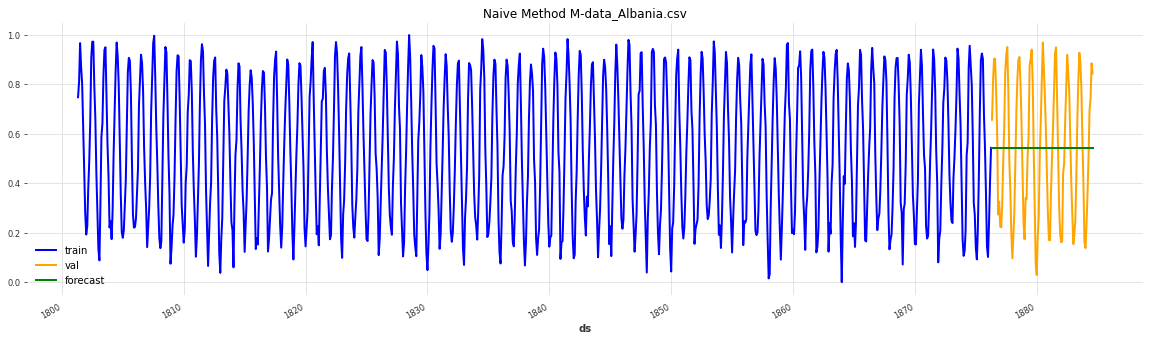

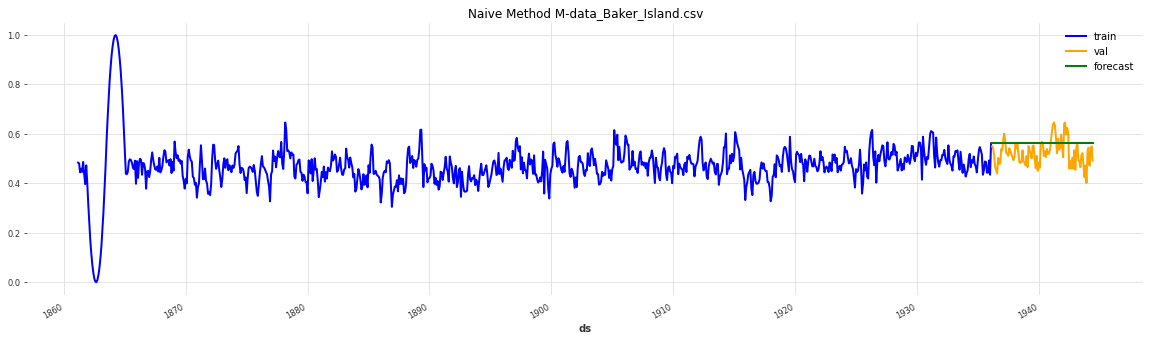

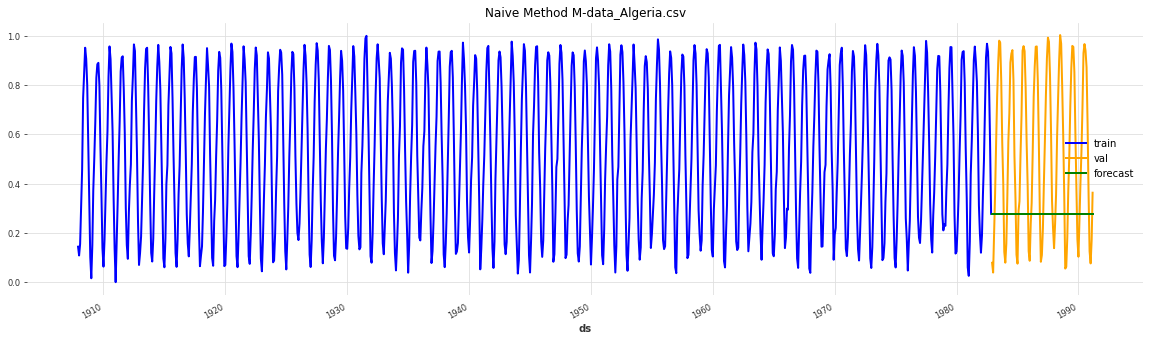

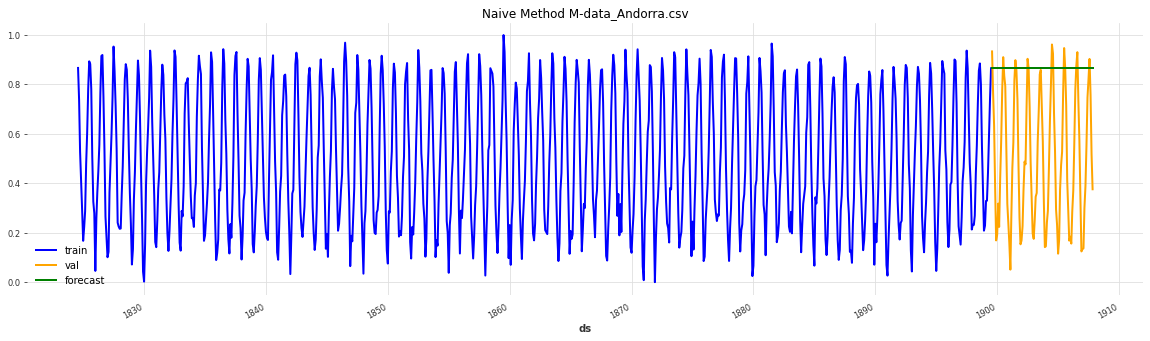

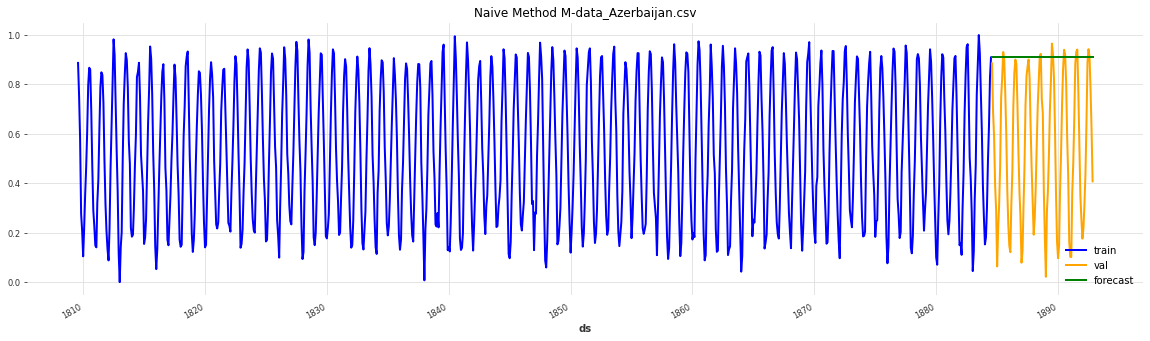

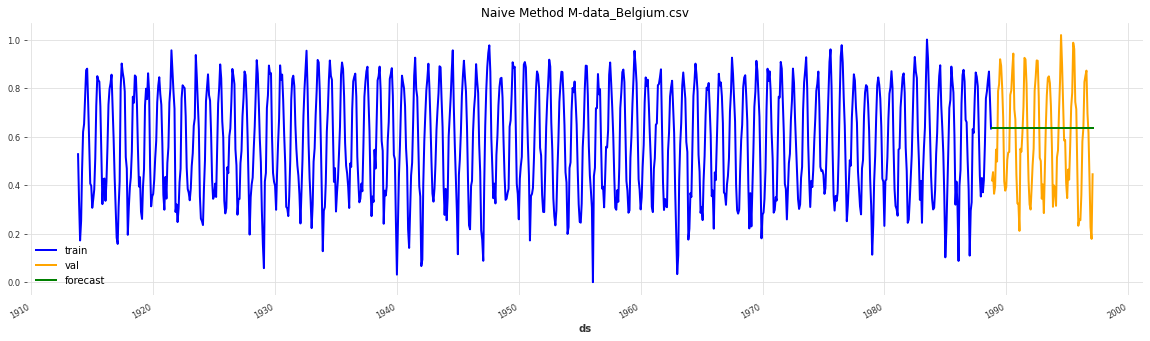

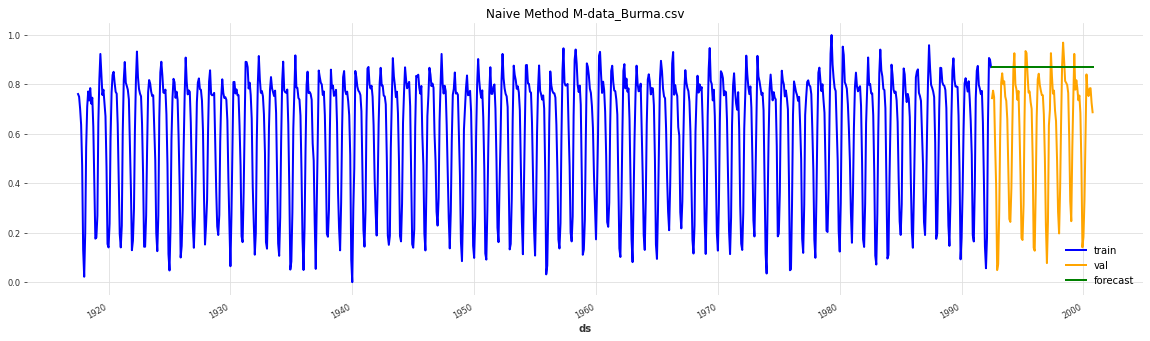

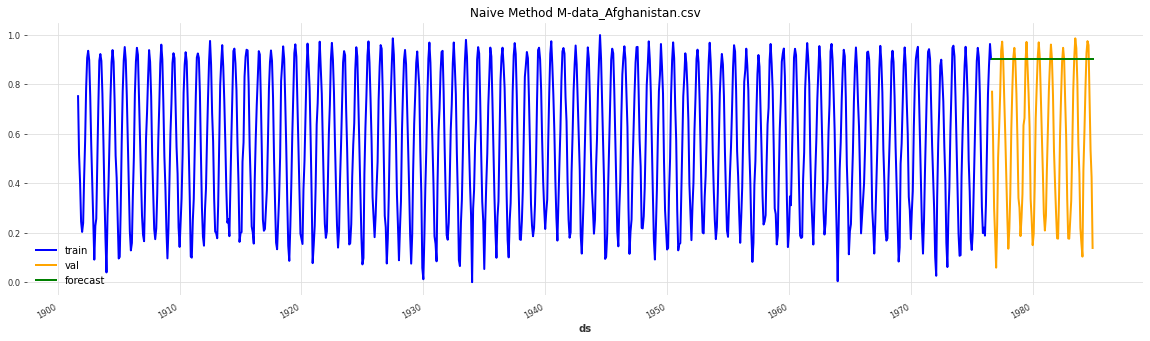

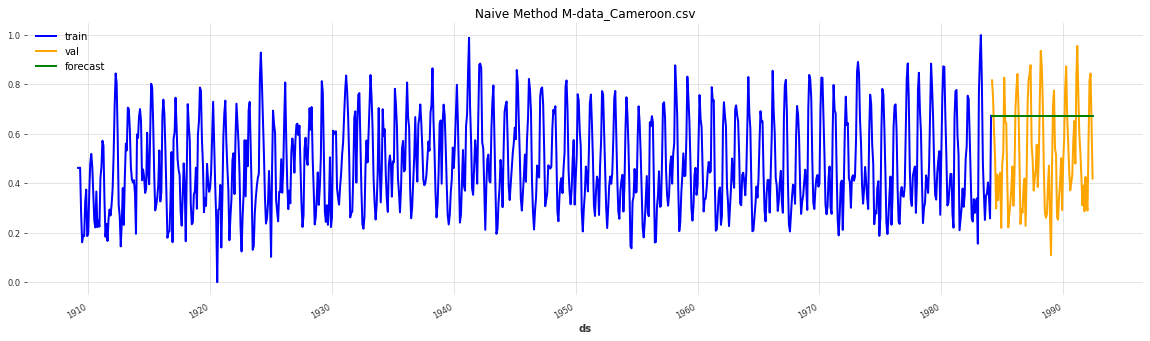

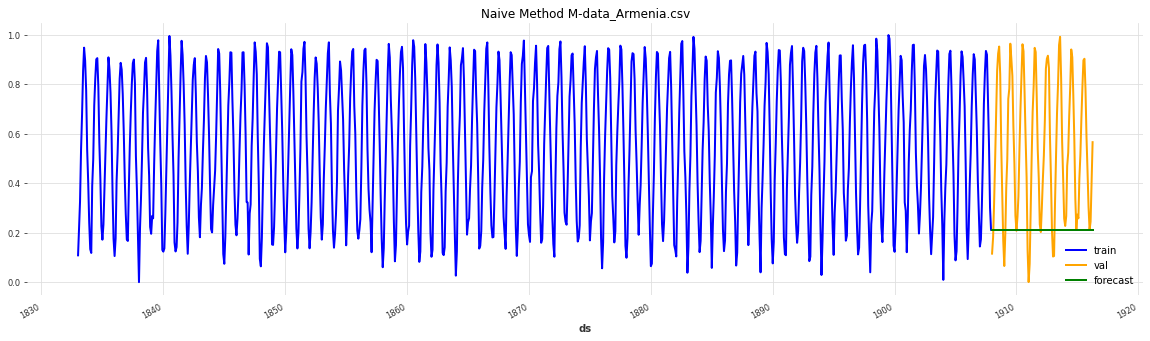

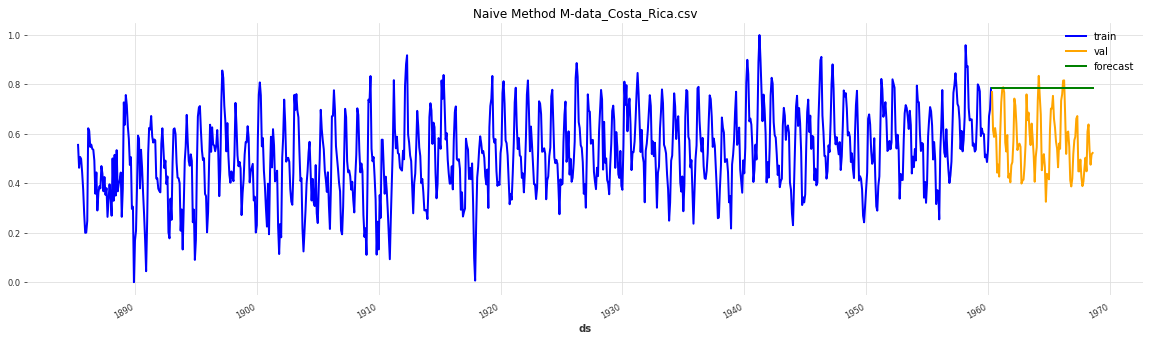

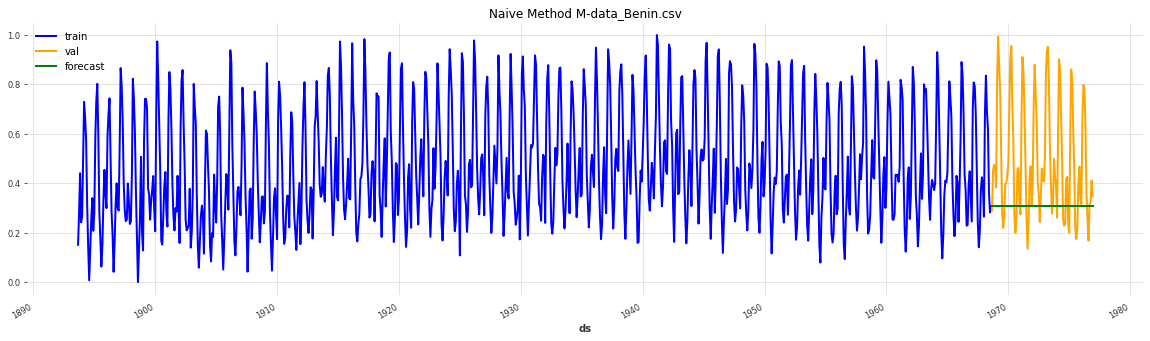

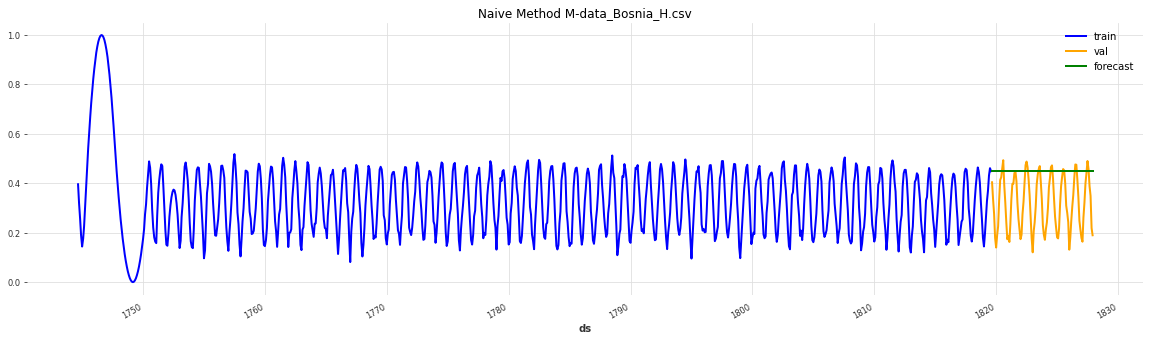

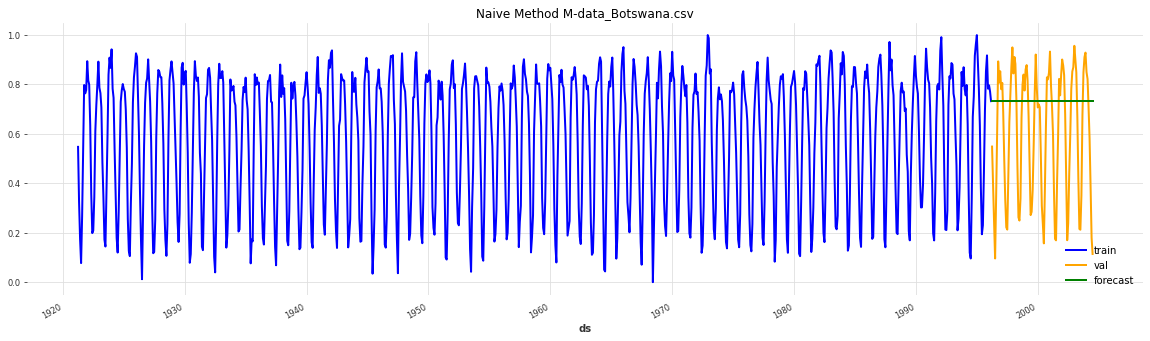

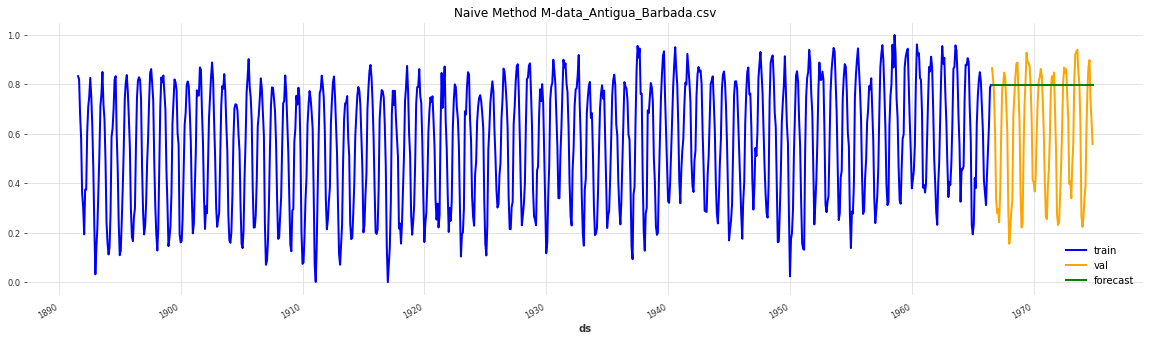

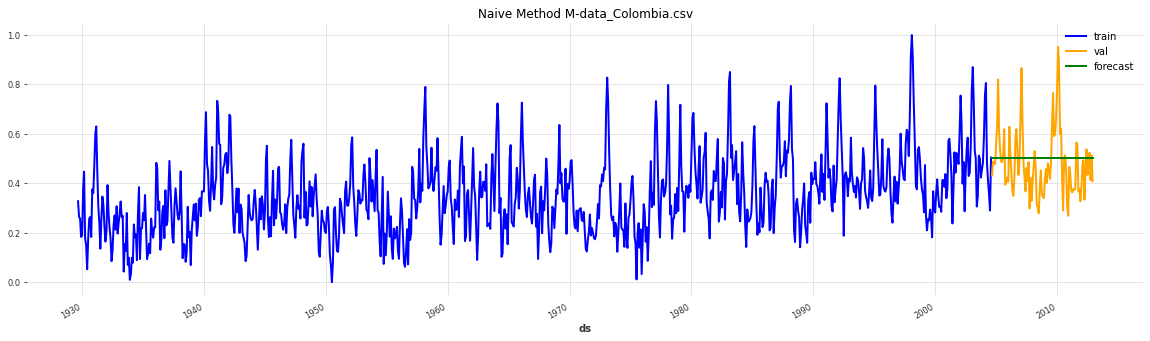

In [18]:
for i in range(len(df_fit_naive)):
    plt.figure(figsize=(20,5))
    df_fit_naive[i].plot(color ='blue', label="train")
    df_true_prediction_naive[i].plot(color ='orange', label="val")
    forecast_naive[i].plot(color ='green',label="forecast")
    plt.title('Naive Method '+file_name[i]+".csv")    
    plt.legend(loc='best')
    plt.show()

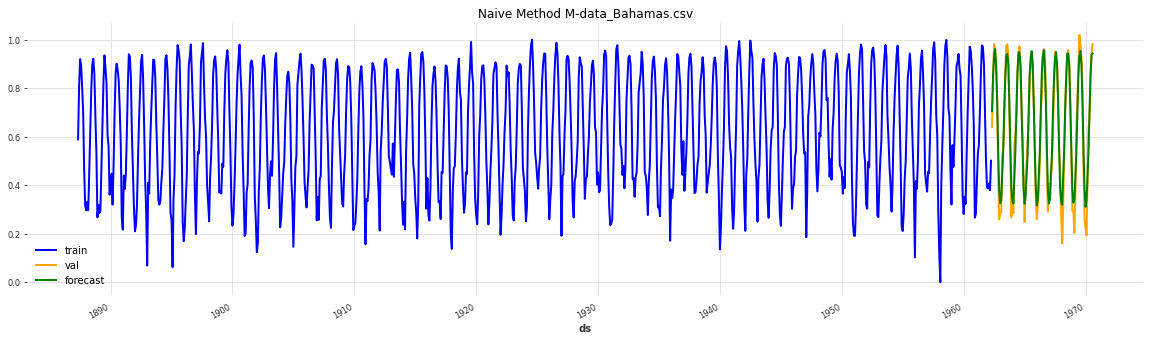

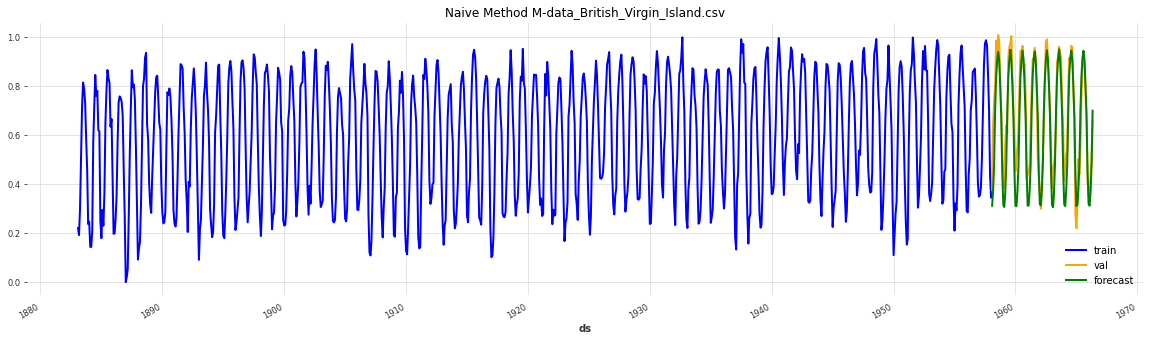

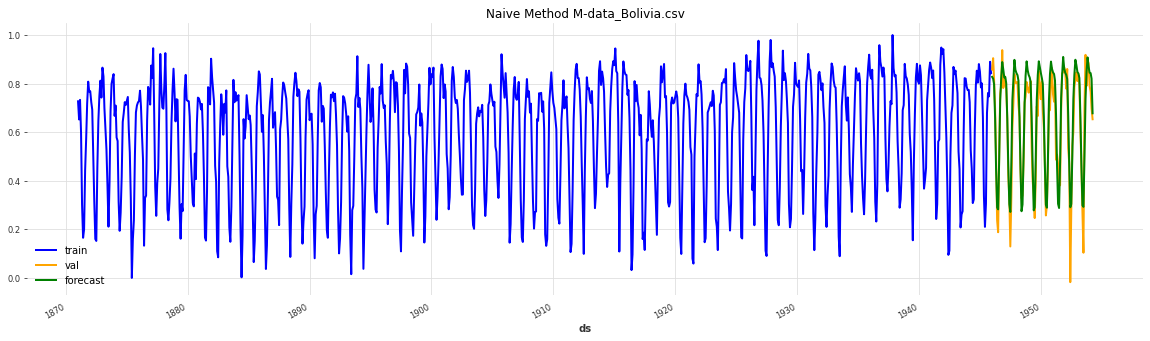

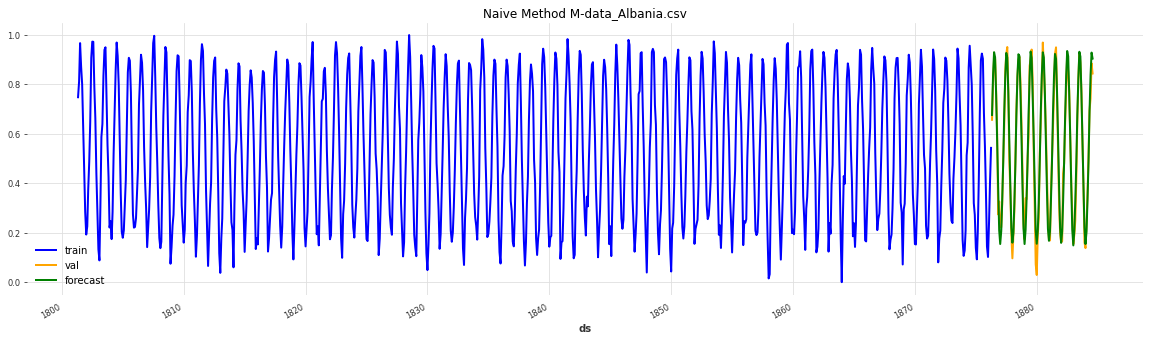

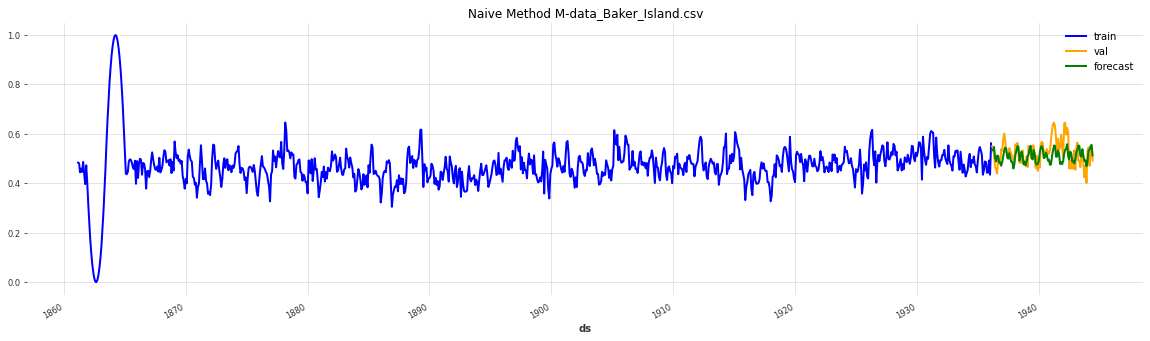

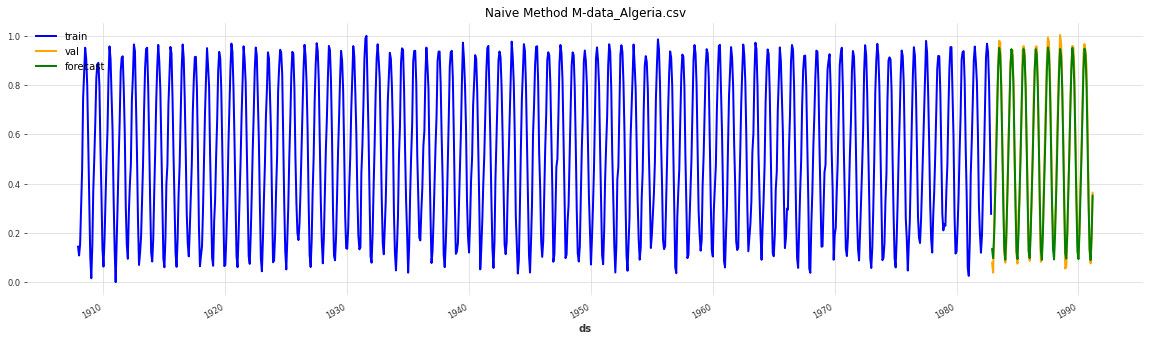

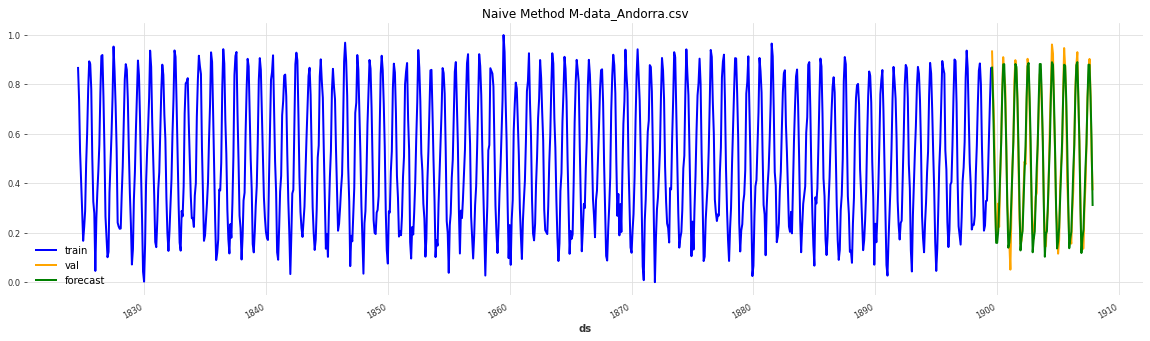

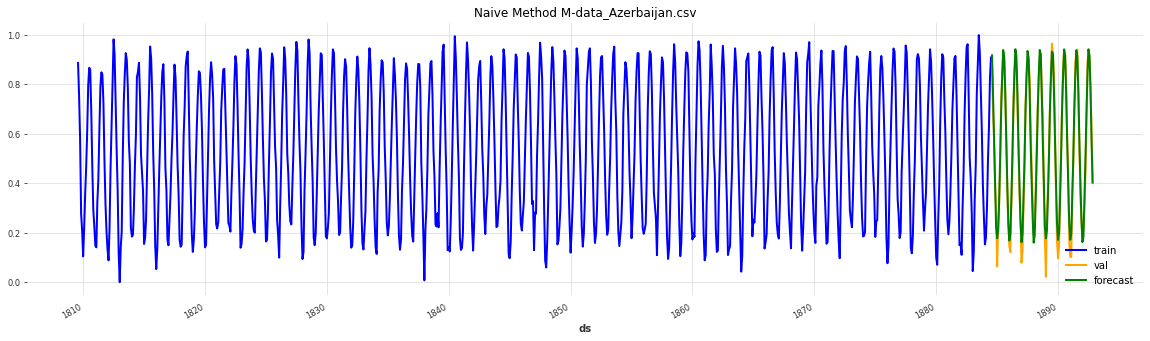

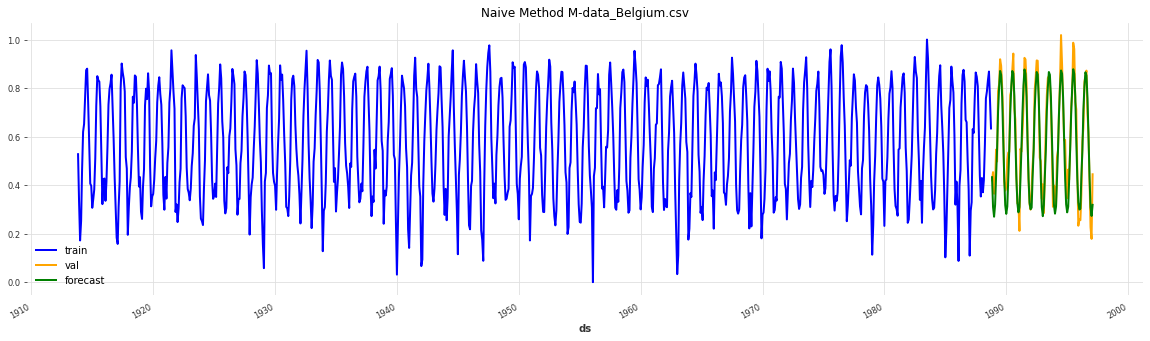

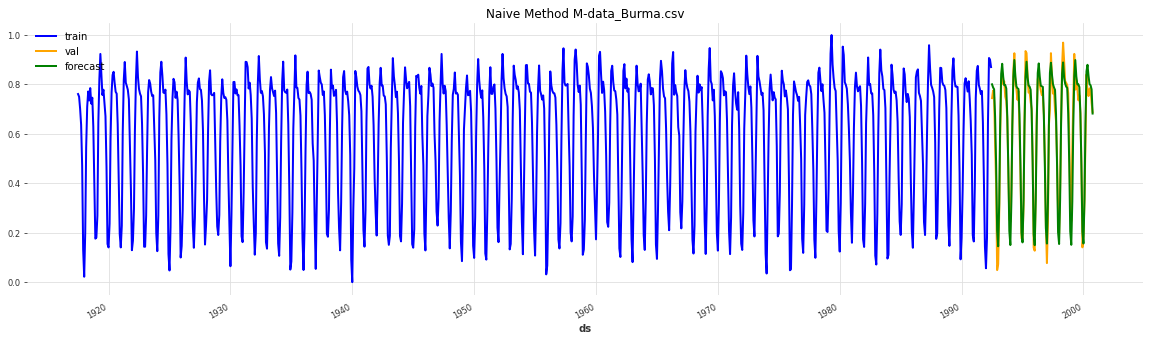

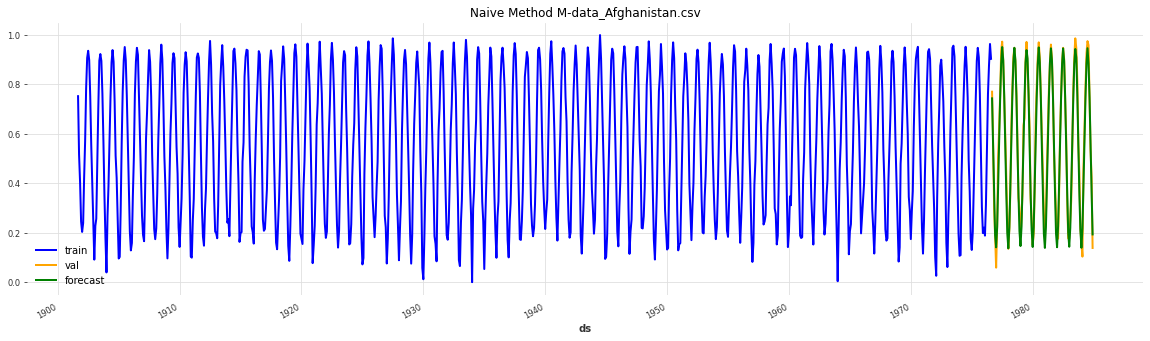

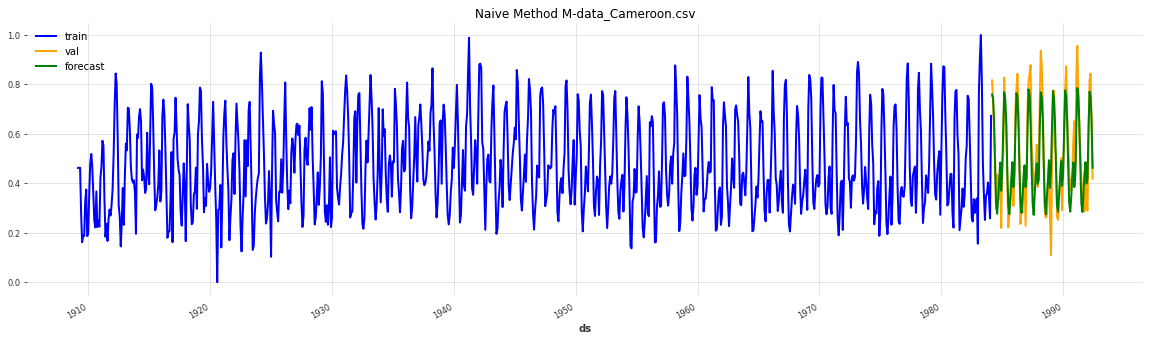

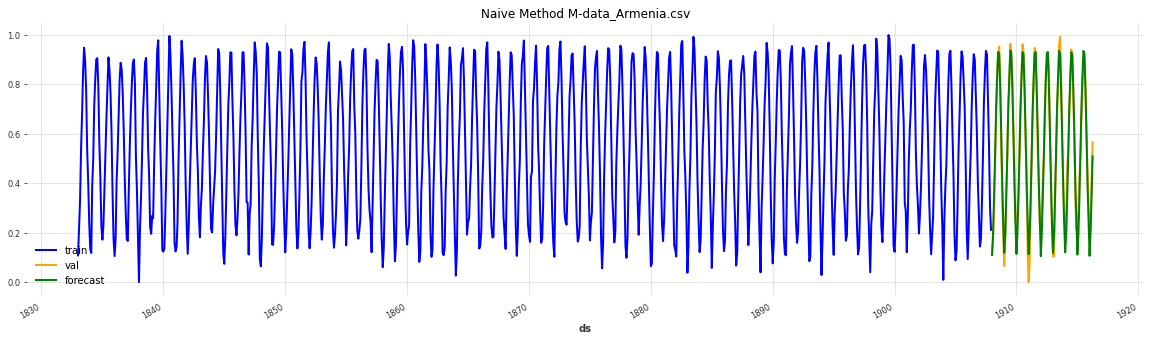

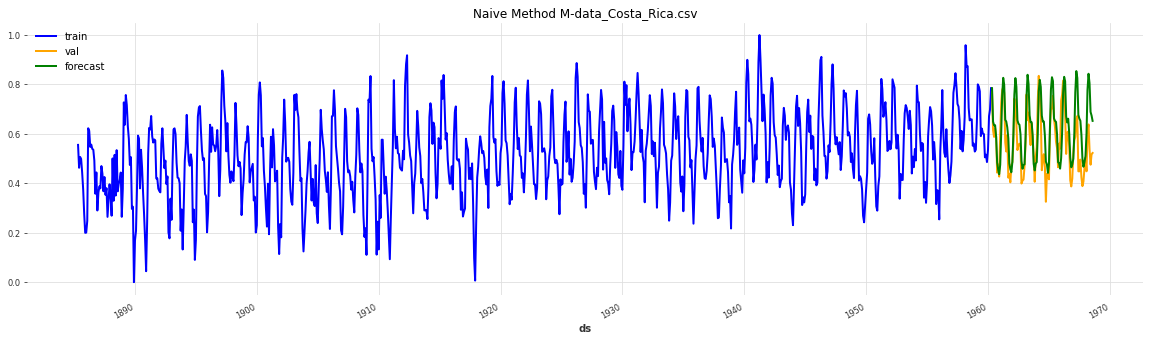

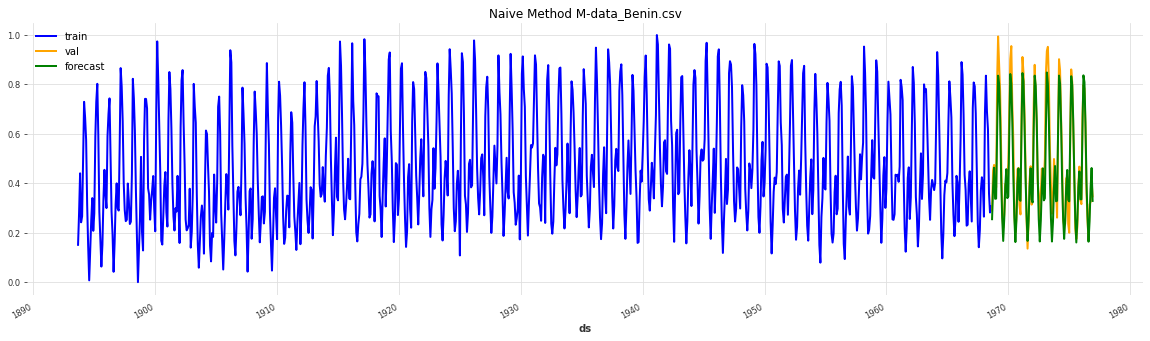

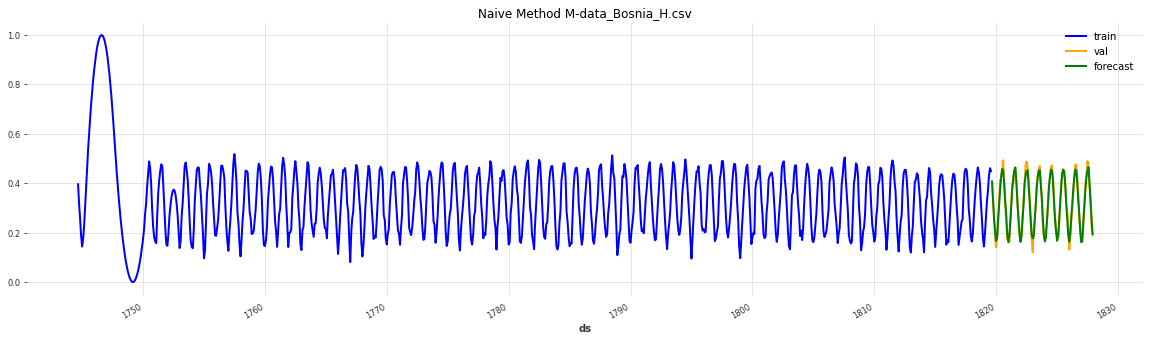

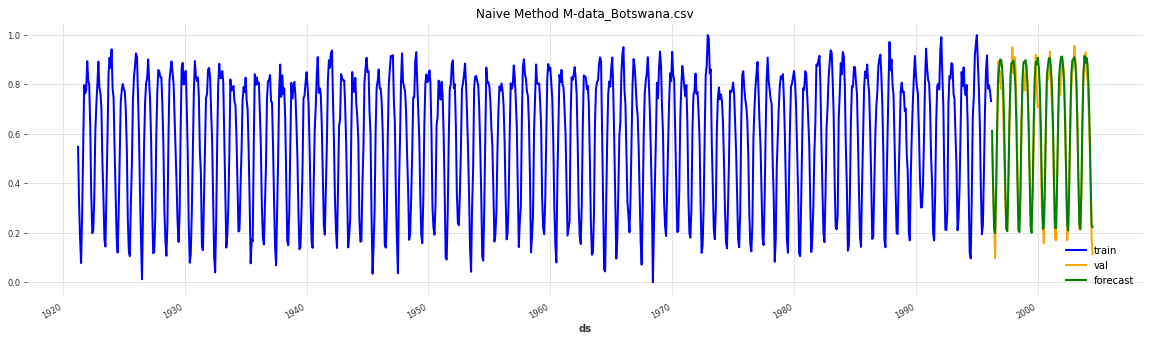

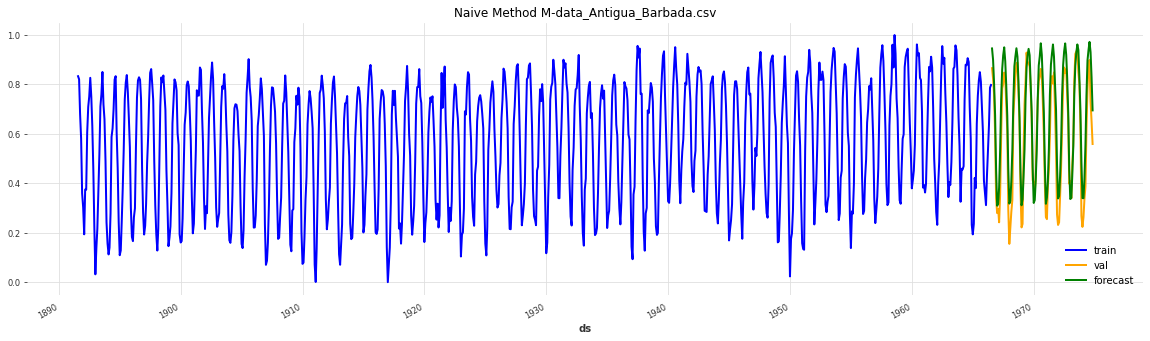

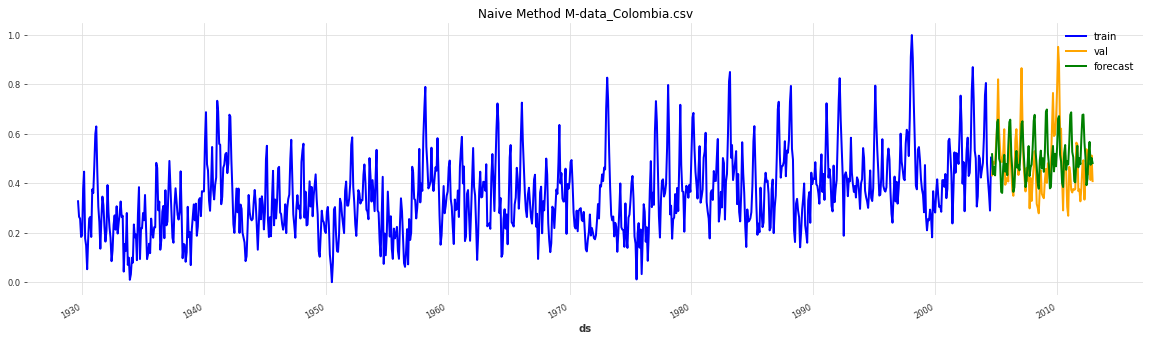

In [19]:
for i in range(len(df_fit_prophet)):
    plt.figure(figsize=(20,5))
    df_fit_prophet[i].plot(color ='blue', label="train")
    df_true_prediction_prophet[i].plot(color ='orange', label="val")
    forecast_prophet[i].plot(color ='green',label="forecast")
    plt.title('Naive Method '+file_name[i]+".csv")    
    plt.legend(loc='best')
    plt.show()

In [20]:
for i in range(len(df_fit_naive)):
    if len(df_fit_naive[i]) != 900 :
        print("ERROR, len(df_fit_naive[{}]) = {}".format(i, len(df_fit_naive[i])))
    elif len(df_true_prediction_naive[i]) != 100 :
        print("ERROR, len(df_true_prediction_naive[{}]) = {}".format(i, len(df_true_prediction_naive[i])))
    else:
        print("Tout est bon pour data i = ", i)
    print("-----")

Tout est bon pour data i =  0
-----
Tout est bon pour data i =  1
-----
Tout est bon pour data i =  2
-----
Tout est bon pour data i =  3
-----
Tout est bon pour data i =  4
-----
Tout est bon pour data i =  5
-----
Tout est bon pour data i =  6
-----
Tout est bon pour data i =  7
-----
Tout est bon pour data i =  8
-----
Tout est bon pour data i =  9
-----
Tout est bon pour data i =  10
-----
Tout est bon pour data i =  11
-----
Tout est bon pour data i =  12
-----
Tout est bon pour data i =  13
-----
Tout est bon pour data i =  14
-----
Tout est bon pour data i =  15
-----
Tout est bon pour data i =  16
-----
Tout est bon pour data i =  17
-----
Tout est bon pour data i =  18
-----


In [21]:
for i in range(len(df_fit_prophet)):
    if len(df_fit_prophet[i]) != 900 :
        print("ERROR, len(df_fit_prophet[{}]) = {}".format(i, len(df_fit_prophet[i])))
    elif len(df_true_prediction_prophet[i]) != 100 :
        print("ERROR, len(df_true_prediction_prophet[{}]) = {}".format(i, len(df_true_prediction_prophet[i])))
    else:
        print("Tout est bon pour data i = ", i)
    print("-----")

Tout est bon pour data i =  0
-----
Tout est bon pour data i =  1
-----
Tout est bon pour data i =  2
-----
Tout est bon pour data i =  3
-----
Tout est bon pour data i =  4
-----
Tout est bon pour data i =  5
-----
Tout est bon pour data i =  6
-----
Tout est bon pour data i =  7
-----
Tout est bon pour data i =  8
-----
Tout est bon pour data i =  9
-----
Tout est bon pour data i =  10
-----
Tout est bon pour data i =  11
-----
Tout est bon pour data i =  12
-----
Tout est bon pour data i =  13
-----
Tout est bon pour data i =  14
-----
Tout est bon pour data i =  15
-----
Tout est bon pour data i =  16
-----
Tout est bon pour data i =  17
-----
Tout est bon pour data i =  18
-----
